# Import libraries

In [42]:
# modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# result
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')          # graph settings
plt.rcParams['figure.figsize'] = (12,5)    # graph settings

# data wrangling
import numpy as np 
import pandas as pd

# corpus
from nltk.corpus import stopwords

# string manipulation
import re
import spacy
import collections

In [43]:
import nltk 
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset

In [75]:
train = pd.read_csv('../content/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('../content/Corona_NLP_test.csv', encoding='latin1')
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Dataset size

In [76]:
print('Examples in train data: {}'.format(len(train)))
print('Examples in test data: {}'.format(len(test)))

Examples in train data: 41157
Examples in test data: 3798


## Missing values

In [77]:
train.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [78]:
# delete because, we dont use it
train = train.drop(columns=["Location","UserName","ScreenName","TweetAt"])
train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Class distribution

In [79]:
dist_train = train['Sentiment'].value_counts()
dist_test = test['Sentiment'].value_counts()

def ditribution_plot(x, y, name):
    sns.barplot(x=x, y=y)
    plt.title(name)
    plt.show()

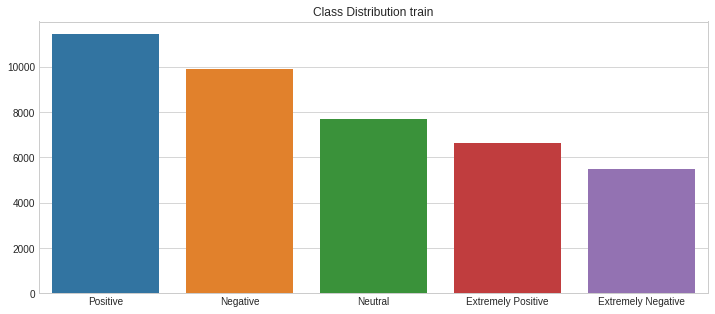

In [80]:
ditribution_plot(x=dist_train.index, y=dist_train.values, name='Class Distribution train')

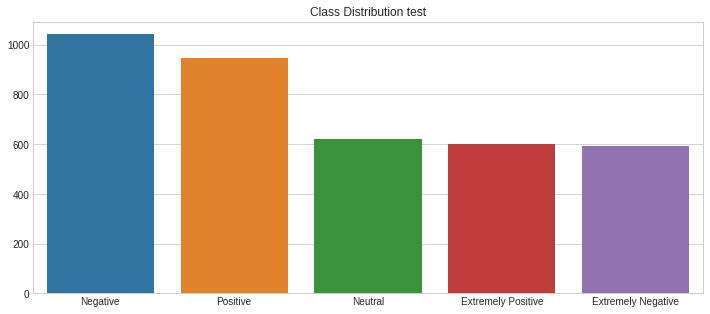

In [81]:
ditribution_plot(x=dist_test.index, y=dist_test.values, name='Class Distribution test')

# Data preprocessing

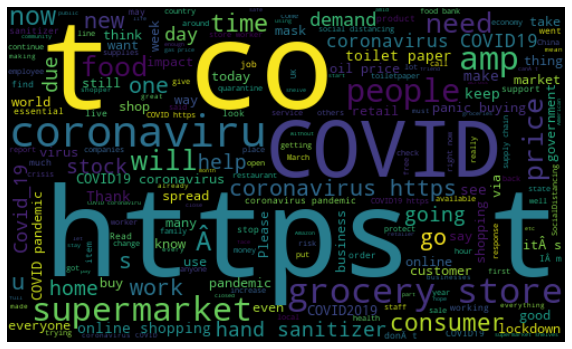

In [82]:
import wordcloud
from wordcloud import WordCloud
allWords = ' '.join([twts for twts in train['OriginalTweet']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [83]:
dtf = train
dtf['word_count'] = dtf["OriginalTweet"].apply(lambda x: len(str(x).split(" ")))
dtf['char_count'] = dtf["OriginalTweet"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
dtf['sentence_count'] = dtf["OriginalTweet"].apply(lambda x: len(str(x).split(".")))
dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
dtf.head()

,OriginalTweet,Sentiment,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,8,104,4,13.000000,2.000000
1,advice Talk to your neighbours family to excha...,Positive,38,200,1,5.263158,38.000000
2,Coronavirus Australia: Woolworths to give elde...,Positive,14,118,2,8.428571,7.000000
3,My food stock is not the only one which is emp...,Positive,40,267,7,6.675000,5.714286
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,38,273,8,7.184211,4.750000


In [84]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

## Cleaning

In [86]:
def data_cleaner(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet)   # remove urls
    tweet = re.sub(r'<.*?>',' ', tweet)      # remove html tags
    tweet = re.sub(r'\d+',' ', tweet)        # remove digits
    tweet = re.sub(r'#\w+',' ', tweet)       # remove hashtags
    tweet = re.sub(r'@\w+',' ', tweet)       # remove mentions
    tweet = " ".join([word for word in tweet.split() if not word in stop_words])   # remove stop words
    return tweet

stop_words = stopwords.words('english')
X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

## Tokenizing

In [87]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
X = tokenizer.texts_to_sequences(X_cleaned)
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[6]))
print("\nAfter tokenizing :\n{}".format(X[6]))

X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[6]))

Vocabulary size: 36117

Example:

Sentence:
Cashier grocery store sharing insights To prove credibility commented "I'm Civics class I know I'm talking about".

After tokenizing :
[1174, 7, 4, 1269, 761, 65, 2902, 9761, 9762, 154, 18316, 1501, 2, 62, 154, 900, 958]

After padding :
[ 1174     7     4  1269   761    65  2902  9761  9762   154 18316  1501
     2    62   154   900   958     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


## Feature encoding

In [88]:
encoding = {
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Extremely Positive': 2
}

labels = ['Negative', 'Neutral', 'Positive']
y.replace(encoding, inplace=True)

# Model building and training

In [89]:
tf.keras.backend.clear_session()

# hyperparameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 54
units = 256

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.GRU(units, return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)
])

model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 54)            1950318   
                                                                 
 bidirectional (Bidirectiona  (None, 54, 512)          479232    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [90]:
history = model.fit(X, y, epochs=2, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/2
1132/1132 [==============================] - 369s 322ms/step - loss: 0.5848 - accuracy: 0.7633 - val_loss: 0.3811 - val_accuracy: 0.8680
Epoch 2/2
1132/1132 [==============================] - 373s 330ms/step - loss: 0.3071 - accuracy: 0.9008 - val_loss: 0.3770 - val_accuracy: 0.8767


After 2 epochs, we get overfitting

In [91]:
def history_plot(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

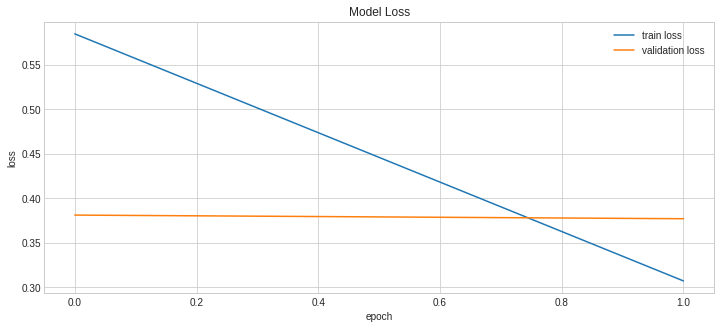

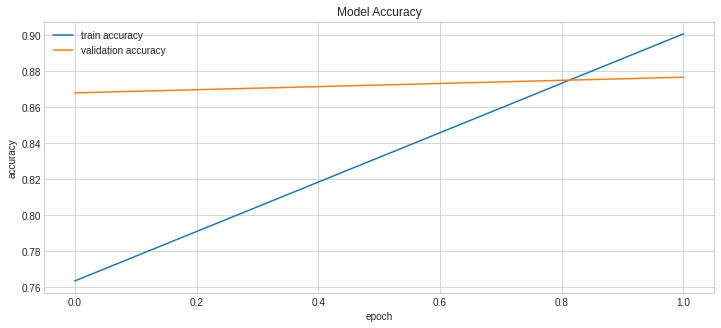

In [92]:
history_plot(history)

# Evaluation

## Preprocessing test data

In [93]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

X_test = X_test.apply(data_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen=X.shape[1])
y_test.replace(encoding, inplace=True)

## Accuracy and loss

In [94]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.44166791439056396
Test Accuracy: 0.8504475951194763


## Confusion matrix

In [95]:
pred = np.argmax(model.predict(X_test), axis=-1)

119/119 [==============================] - 11s 83ms/step


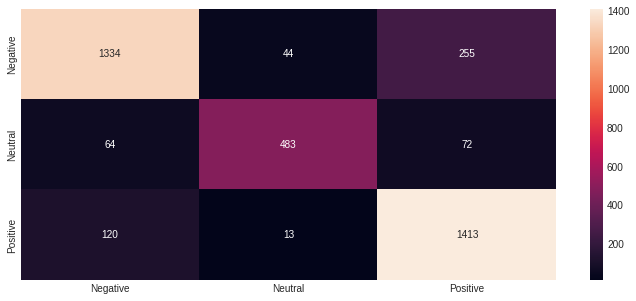

In [96]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

sns.heatmap(cm, annot=True, fmt="d")
plt.show()

## Classification report

In [97]:
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

    Negative       0.88      0.82      0.85      1633
     Neutral       0.89      0.78      0.83       619
    Positive       0.81      0.91      0.86      1546

    accuracy                           0.85      3798
   macro avg       0.86      0.84      0.85      3798
weighted avg       0.85      0.85      0.85      3798

